In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
data = pd.read_csv("bank_marketing_cleaned.csv")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contacted_before,pdays_clean,previous_capped,campaign_winsorized
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,NaN,0,1


In [26]:
data.shape

(41176, 24)

**Target Variable Overview**

In [27]:
data['y'].dtype


dtype('int64')

In [28]:
print(data['y'].isnull().sum())
print(data['y'].unique())


0
[0 1]


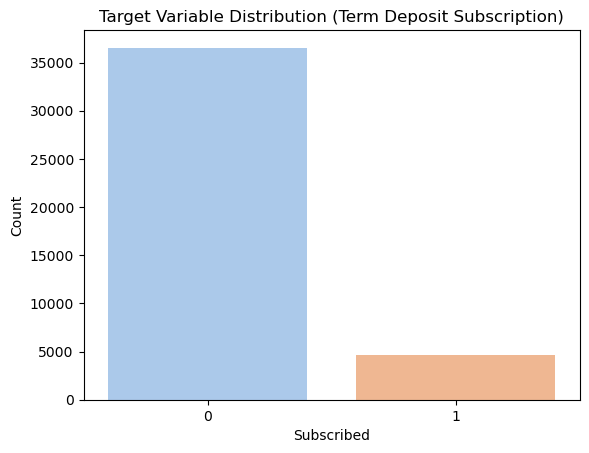

In [29]:
sns.countplot(x='y', data=data, palette='pastel')
plt.title("Target Variable Distribution (Term Deposit Subscription)")
plt.xlabel("Subscribed")
plt.ylabel("Count")
plt.show()


The bar for "0" (not subscribed) is significantly taller, indicating that most customers did not subscribe to the term deposit.

The bar for "1" (subscribed) is much shorter, showing that only a small fraction of customers subscribed.

**Numeric Features Distributions**

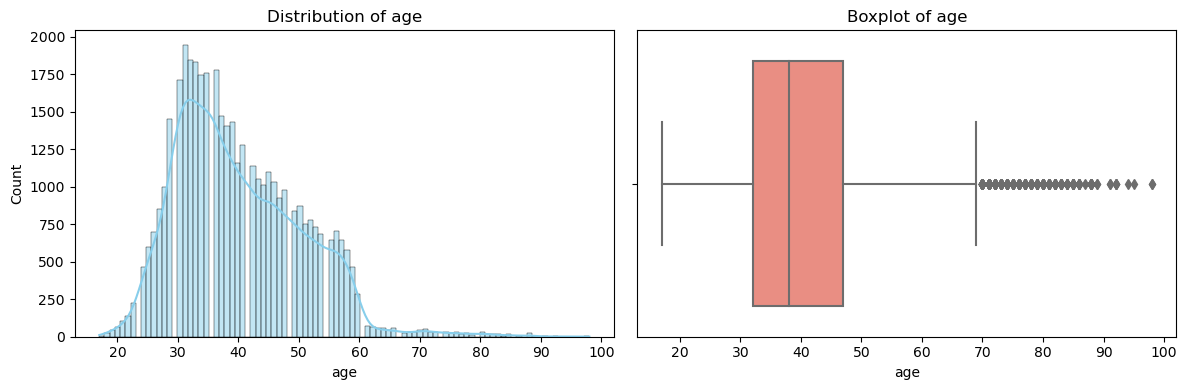

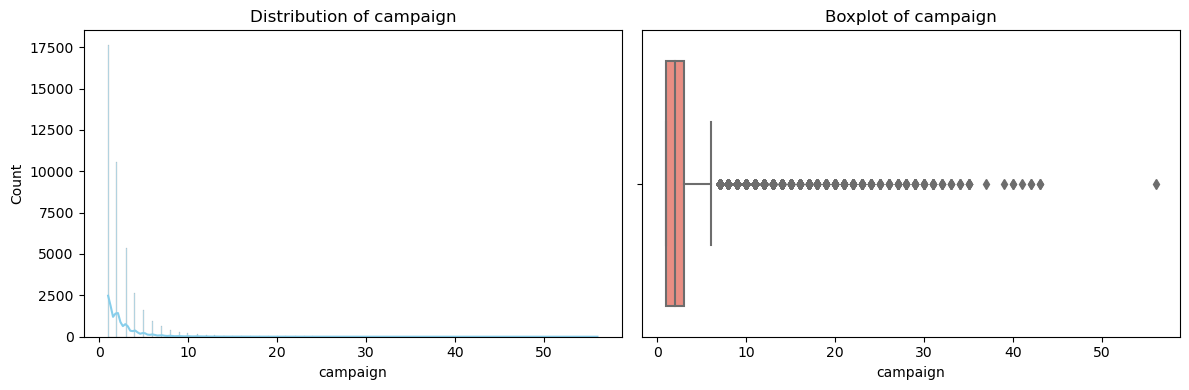

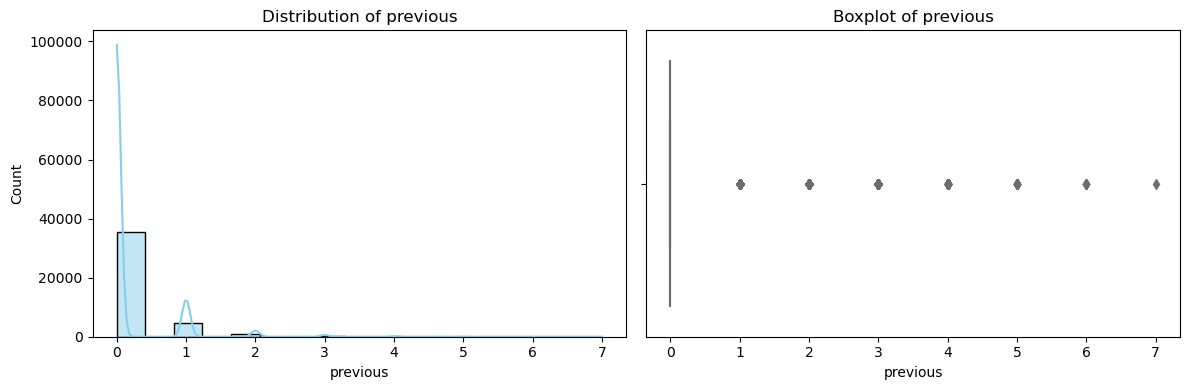

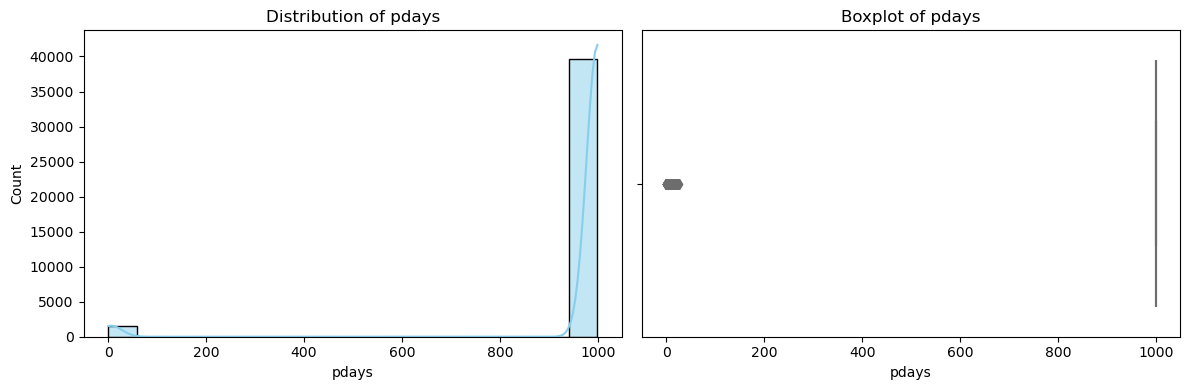

In [30]:
numeric_cols = ['age', 'campaign', 'previous', 'pdays']

for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(data[col], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {col}')
    
    sns.boxplot(x=data[col], ax=axes[1], color='salmon')
    axes[1].set_title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()


Age

The data is skewed toward younger/middle-aged adults, with fewer older individuals. The box plot confirms the skewness and highlights the central tendency and spread.

Campaign

The Histogram shows data is highly right-skewed, indicating most clients received minimal follow-ups, while a tiny subset was contacted excessively.

The boxplot shows Whiskers/Outliers:

    Whiskers may extend to ~10–20 contacts.

    Dots beyond whiskers represent extreme outliers (clients contacted 20+ times).


Pdays

The "pdays" variable has a very skewed distribution, with a lot of people at the extremes—especially at 1000, which often signifies "never contacted since the last campaign."

**Categorical Features vs Subscription Rate**

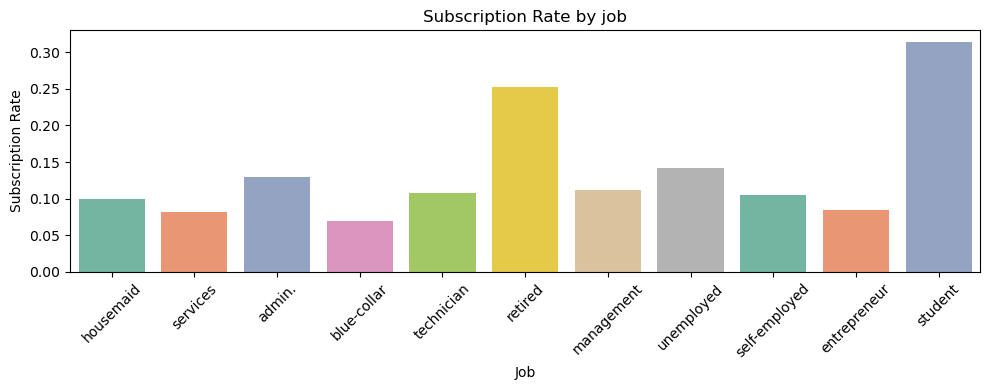

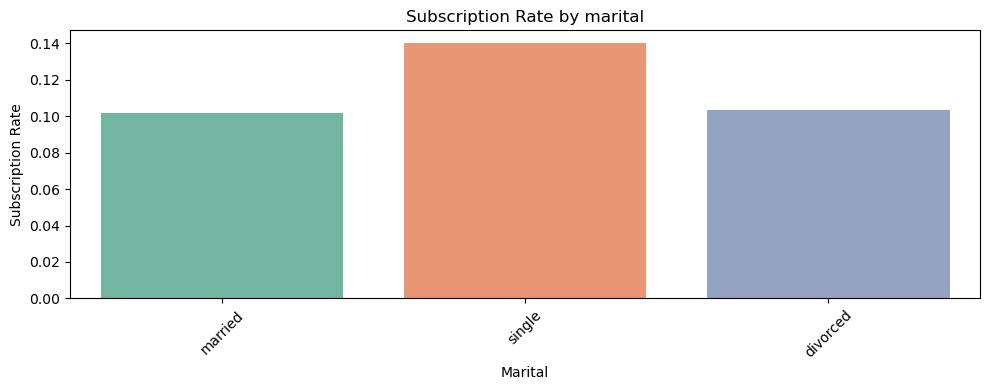

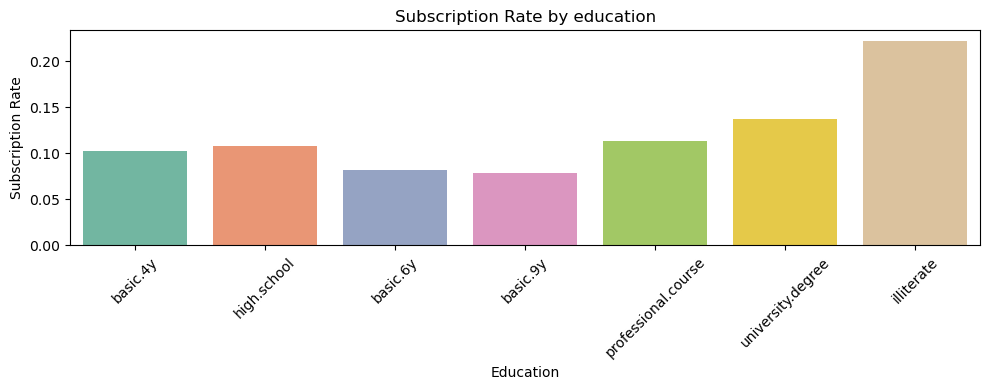

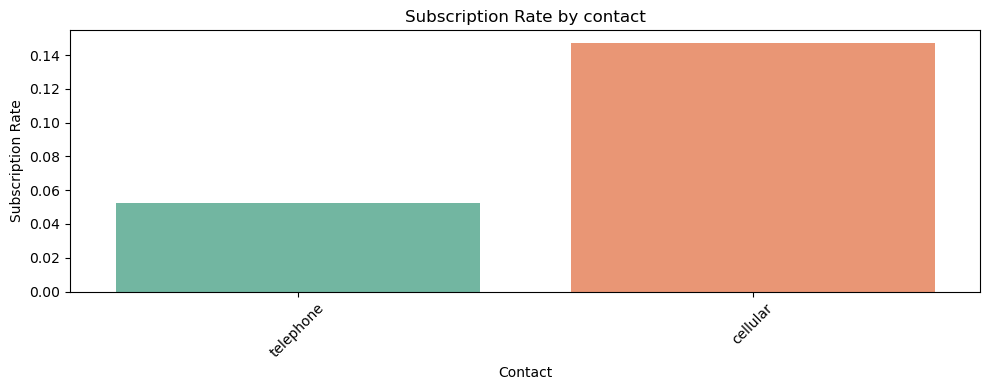

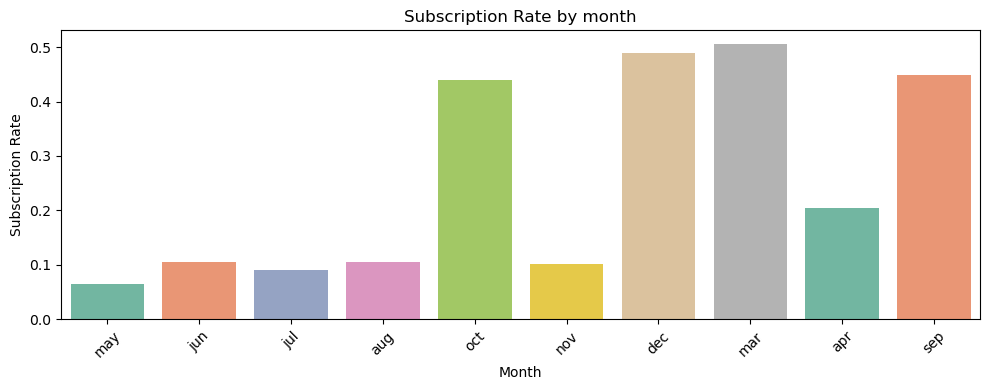

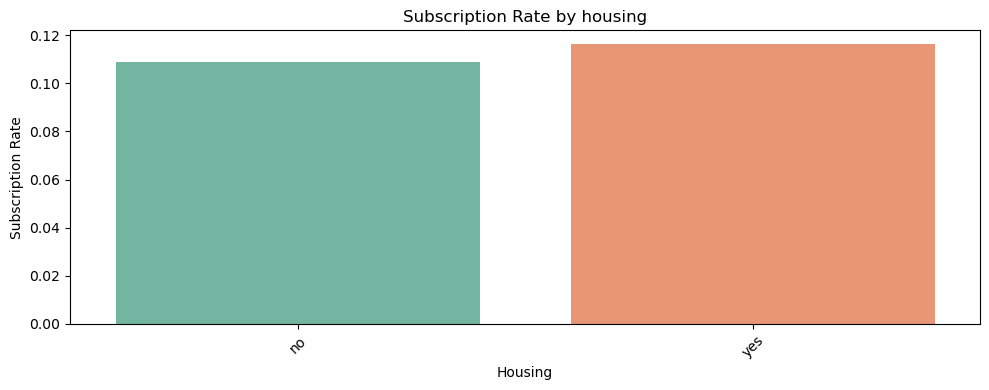

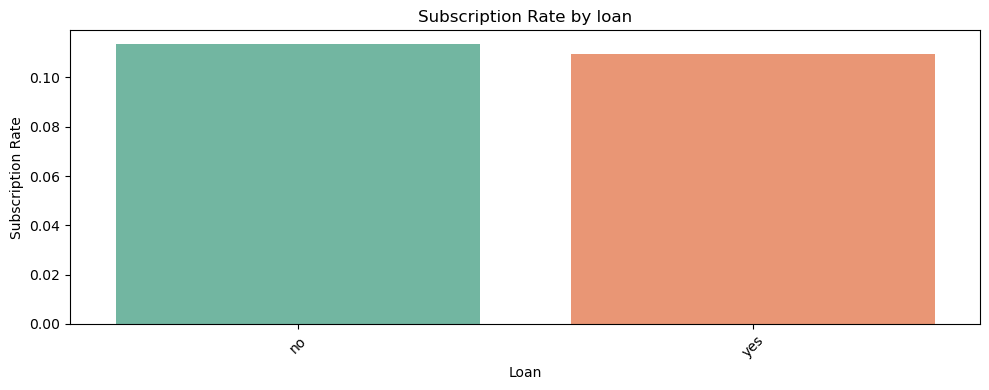

In [32]:
cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'housing', 'loan']

for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.barplot(x=col, y='y', data=data, estimator=lambda x: sum(x) / len(x), errorbar=None, palette='Set2')
    plt.xticks(rotation=45)
    plt.title(f"Subscription Rate by {col}")
    plt.ylabel("Subscription Rate")
    plt.xlabel(col.capitalize())
    plt.tight_layout()
    plt.show()


Subscription Rate by Jobs: Highest rate(Students) — young, impressionable, potentially seeking savings tools
    
Subscription Rate by Maritals : Highest rate(Single) 

Subscription Rate by Education : Highest rate(illiterate)

Subscription Rate by contact : Highest rate(cellular)

Subscription Rate by loan : Highestst rate(no loan)


    

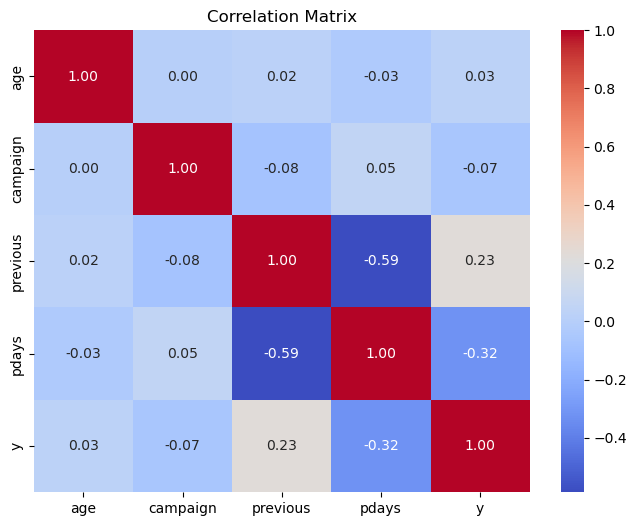

In [33]:
import numpy as np

corr_cols = ['age', 'campaign', 'previous', 'pdays', 'y']
plt.figure(figsize=(8, 6))
sns.heatmap(data[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


Strongest relationship (negative): pdays and previous have a notable negative correlation of -0.59, suggesting that as the number of previous contacts increases, the days since last contact (pdays) tend to decrease


Target variable (y) insights:

- previous shows the highest positive correlation with y at 0.23.
- pdays has the strongest negative correlation with y at -0.32.
- That might hint that recent or more frequent contact increases the likelihood of a positive outcome (like a conversion or response, depending on what y represents).


### Insights on Contact Behavior ###

**1.Campaign vs Conversion Rate:**

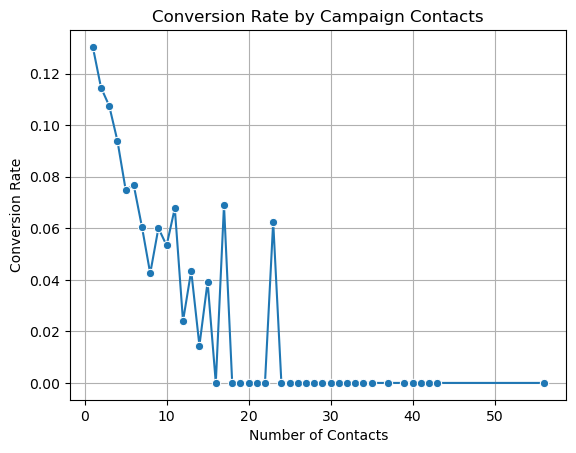

In [36]:
sns.lineplot(
    x='campaign',
    y='y',
    data=data.groupby('campaign')['y'].mean().reset_index(),
    marker='o'
)
plt.title('Conversion Rate by Campaign Contacts')
plt.xlabel('Number of Contacts')
plt.ylabel('Conversion Rate')
plt.grid(True)
plt.show()


Conversion rates decline steadily as the number of campaign contacts increases.

At zero contacts, conversion sits high around 12%, but after around 20 contacts, the rate drops to 0% and stays there—even   when contacts reach 50.


    

**2.Contacts by Month**

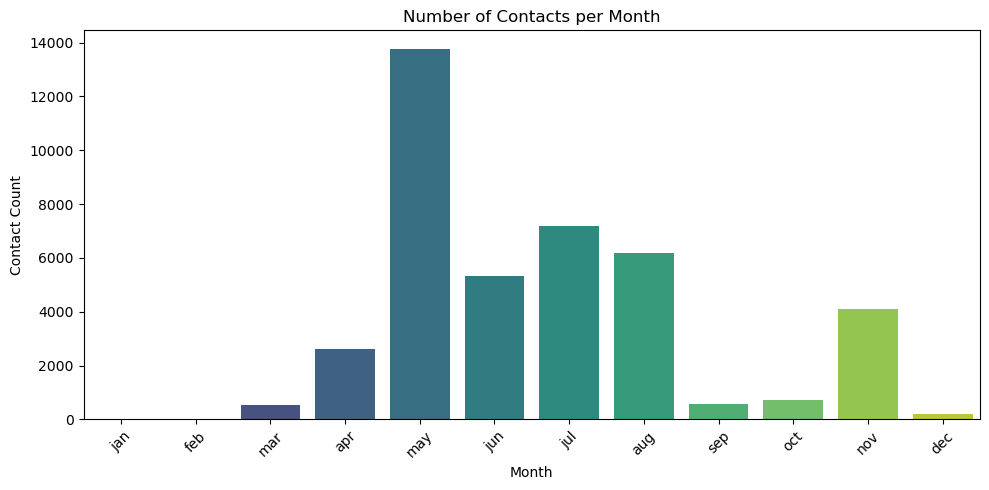

In [40]:


plt.figure(figsize=(10, 5))
sns.countplot(x='month', data=data, order=month_order, palette='viridis')
plt.title("Number of Contacts per Month")
plt.ylabel("Contact Count")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**3.Conversion Rate by month**

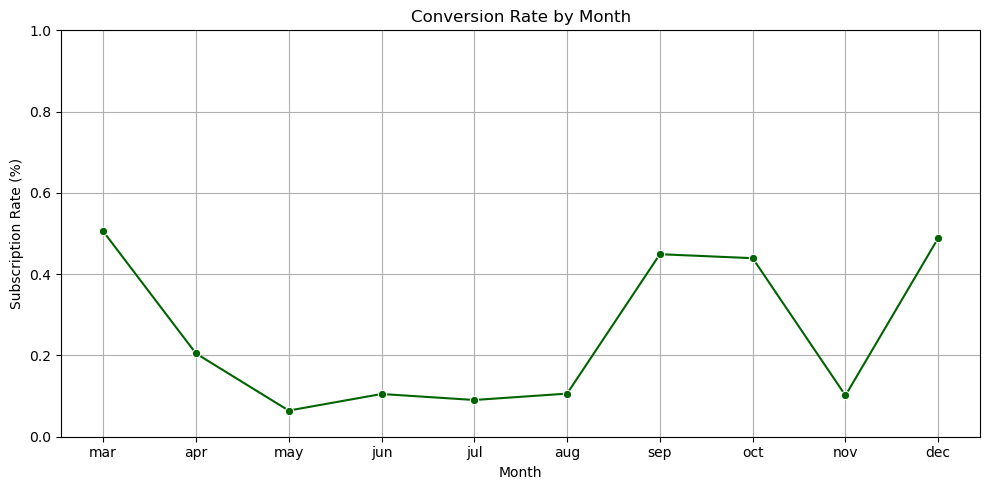

In [39]:

# Ensure month is lowercase and standardized
data['month'] = data['month'].str.lower()

# Define the correct month order
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Convert to categorical for ordered plotting
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

# Calculate conversion rate per month
conversion_by_month = data.groupby('month')['y'].mean().reindex(month_order)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=conversion_by_month.index, y=conversion_by_month.values, marker='o', color='darkgreen')
plt.title("Conversion Rate by Month")
plt.ylabel("Subscription Rate (%)")
plt.xlabel("Month")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


- March starts strong at ~0.6%, but…
- May is alarmingly low, dipping to ~0.1%—and that’s during the same month we saw the highest contact volume earlier.
- Rates stay flat through June to August, then see a notable rebound in September and October (back to ~0.5%).
- Another dip hits November, followed by a slight recovery in December.
